# Pokémon sprite generation 

In [1]:
import os
import requests
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
from pathlib import Path

# Set up data directory
data_dir = Path("../data")
data_dir.mkdir(exist_ok=True)

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Download Pokémon Black and White sprite set with caching
def download_pokemon_sprites():
    # URL for Pokémon Black/White sprites from a reliable source
    # Using PokeAPI sprites which has Gen 5 (Black/White) sprites
    sprite_dir = data_dir / "pokemon_sprites"
    sprite_dir.mkdir(exist_ok=True)
    
    print("Downloading Pokémon Black/White sprites...")
    
    # We'll download sprites for the first 150 Pokémon (original + some from later gens)
    pokemon_ids = list(range(1, 151))  # First 150 Pokémon
    
    downloaded_count = 0
    cached_count = 0
    failed_downloads = []
    
    for pokemon_id in pokemon_ids:
        sprite_path = sprite_dir / f"pokemon_{pokemon_id:03d}.png"
        
        # Check if file already exists and is valid
        if sprite_path.exists() and sprite_path.stat().st_size > 0:
            cached_count += 1
            if cached_count % 10 == 0:
                print(f"Found {cached_count} cached sprites...")
            continue
        
        try:
            # Use PokeAPI for Black/White sprites (Generation 5)
            sprite_url = f"https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/versions/generation-v/black-white/{pokemon_id}.png"
            
            response = requests.get(sprite_url, timeout=10)
            if response.status_code == 200:
                with open(sprite_path, 'wb') as f:
                    f.write(response.content)
                downloaded_count += 1
                
                if downloaded_count % 10 == 0:
                    print(f"Downloaded {downloaded_count} new sprites...")
            else:
                failed_downloads.append(pokemon_id)
                
        except Exception as e:
            print(f"Failed to download sprite for Pokémon {pokemon_id}: {e}")
            failed_downloads.append(pokemon_id)
    
    total_available = cached_count + downloaded_count
    print(f"\nDownload complete!")
    print(f"Found cached: {cached_count} sprites")
    print(f"Downloaded new: {downloaded_count} sprites")
    print(f"Total available: {total_available} sprites")
    print(f"Failed downloads: {len(failed_downloads)}")
    
    return sprite_dir, total_available

# Download the sprites
sprite_directory, total_downloaded = download_pokemon_sprites()

Downloaded 10 new sprites...
Downloaded 20 new sprites...
Downloaded 30 new sprites...
Downloaded 40 new sprites...
Downloaded 50 new sprites...
Downloaded 60 new sprites...
Downloaded 70 new sprites...
Downloaded 80 new sprites...
Downloaded 90 new sprites...
Downloaded 100 new sprites...
Downloaded 110 new sprites...
Downloaded 120 new sprites...
Downloaded 130 new sprites...
Downloaded 140 new sprites...
Downloaded 150 new sprites...

Download complete!
Found cached: 0 sprites
Downloaded new: 150 sprites
Total available: 150 sprites
Failed downloads: 0


Available sprites in ../data/pokemon_sprites: 150


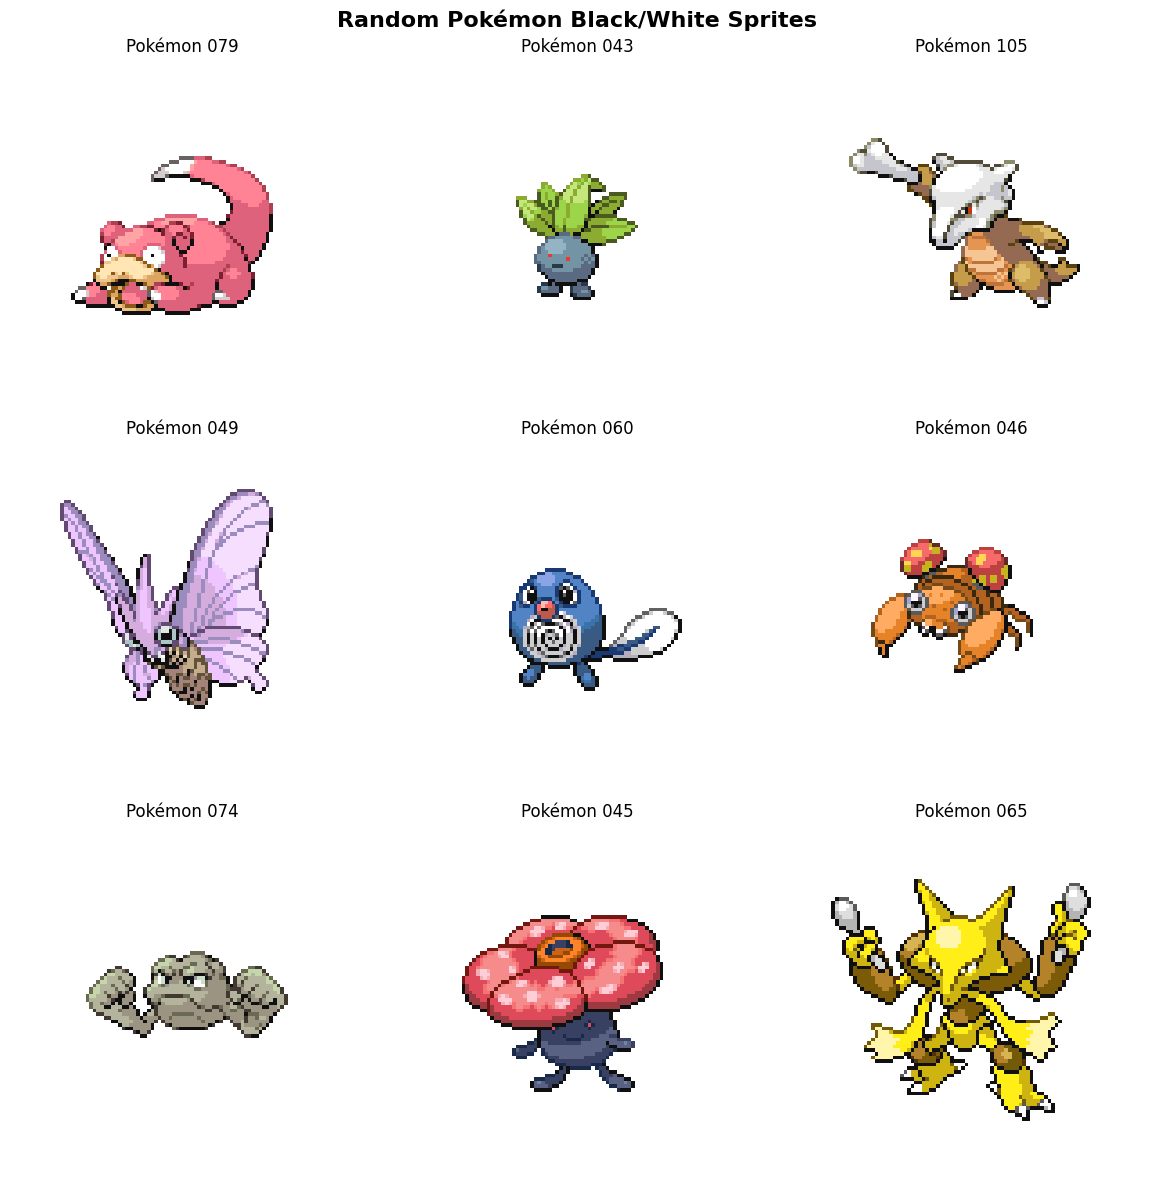

In [3]:
# Function to load and display random Pokémon sprites
def display_random_sprites(sprite_dir, num_sprites=6):
    """Display random Pokémon sprites in a grid"""
    
    # Get all available sprite files
    sprite_files = list(sprite_dir.glob("*.png"))
    
    if len(sprite_files) == 0:
        print("No sprite files found!")
        return
    
    # Select random sprites
    selected_sprites = random.sample(sprite_files, min(num_sprites, len(sprite_files)))
    
    # Calculate grid dimensions
    cols = 3
    rows = (len(selected_sprites) + cols - 1) // cols
    
    # Create the plot
    fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))
    fig.suptitle("Random Pokémon Black/White Sprites", fontsize=16, fontweight='bold')
    
    # Handle case where we have only one row
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    # Display sprites
    for i, sprite_file in enumerate(selected_sprites):
        row = i // cols
        col = i % cols
        
        try:
            # Load and display the image
            img = Image.open(sprite_file)
            axes[row, col].imshow(img)
            axes[row, col].set_title(f"Pokémon {sprite_file.stem.split('_')[1]}", fontsize=12)
            axes[row, col].axis('off')
            
        except Exception as e:
            print(f"Error loading {sprite_file}: {e}")
            axes[row, col].text(0.5, 0.5, 'Error\nLoading\nImage', 
                               ha='center', va='center', transform=axes[row, col].transAxes)
            axes[row, col].axis('off')
    
    # Hide any empty subplots
    for i in range(len(selected_sprites), rows * cols):
        row = i // cols
        col = i % cols
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return selected_sprites

# Display some random sprites
print(f"Available sprites in {sprite_directory}: {len(list(sprite_directory.glob('*.png')))}")
random_sprites = display_random_sprites(sprite_directory, num_sprites=9)

Analyzing 150 Pokémon sprites...

=== Sprite Analysis Results ===
Sample size: 20 sprites
Dimensions:
  Width: 96 - 96 pixels (avg: 96.0)
  Height: 96 - 96 pixels (avg: 96.0)
File sizes: 465 - 1330 bytes (avg: 856.4)
Transparency: 0/20 sprites have transparency


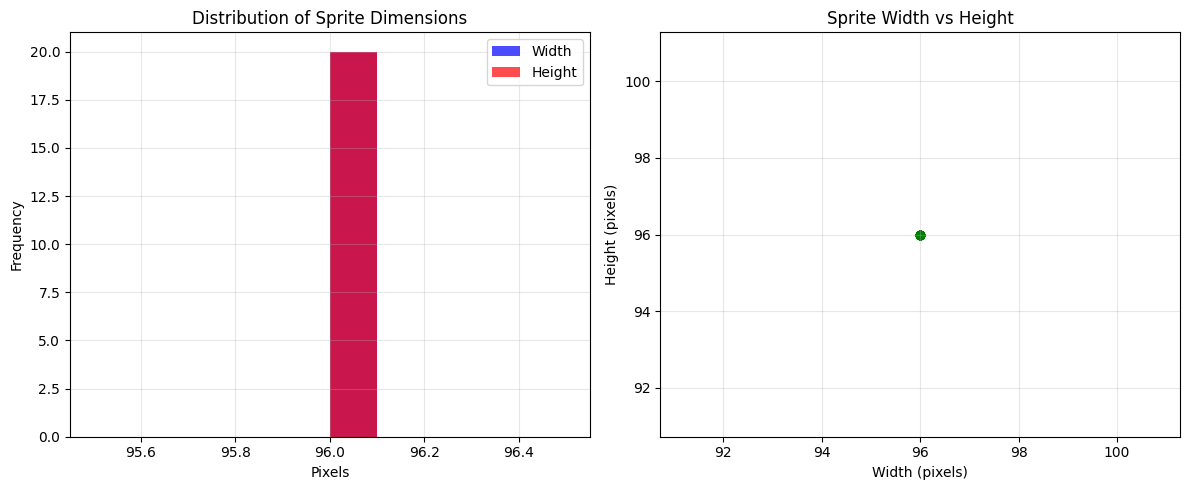

In [4]:
# Analyze sprite characteristics
def analyze_sprites(sprite_dir):
    """Analyze the downloaded sprites to understand their characteristics"""
    
    sprite_files = list(sprite_dir.glob("*.png"))
    
    if len(sprite_files) == 0:
        print("No sprites to analyze!")
        return
    
    print(f"Analyzing {len(sprite_files)} Pokémon sprites...")
    
    # Lists to store sprite properties
    widths, heights, file_sizes = [], [], []
    has_transparency = []
    
    for sprite_file in sprite_files[:20]:  # Analyze first 20 for speed
        try:
            img = Image.open(sprite_file)
            widths.append(img.width)
            heights.append(img.height)
            file_sizes.append(sprite_file.stat().st_size)
            has_transparency.append(img.mode in ('RGBA', 'LA'))
            
        except Exception as e:
            print(f"Error analyzing {sprite_file}: {e}")
    
    # Display analysis results
    print(f"\n=== Sprite Analysis Results ===")
    print(f"Sample size: {len(widths)} sprites")
    print(f"Dimensions:")
    print(f"  Width: {np.min(widths)} - {np.max(widths)} pixels (avg: {np.mean(widths):.1f})")
    print(f"  Height: {np.min(heights)} - {np.max(heights)} pixels (avg: {np.mean(heights):.1f})")
    print(f"File sizes: {np.min(file_sizes)} - {np.max(file_sizes)} bytes (avg: {np.mean(file_sizes):.1f})")
    print(f"Transparency: {sum(has_transparency)}/{len(has_transparency)} sprites have transparency")
    
    # Create a visualization of sprite sizes
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Histogram of widths and heights
    ax1.hist(widths, bins=10, alpha=0.7, label='Width', color='blue')
    ax1.hist(heights, bins=10, alpha=0.7, label='Height', color='red')
    ax1.set_xlabel('Pixels')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distribution of Sprite Dimensions')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Scatter plot of width vs height
    ax2.scatter(widths, heights, alpha=0.7, color='green')
    ax2.set_xlabel('Width (pixels)')
    ax2.set_ylabel('Height (pixels)')
    ax2.set_title('Sprite Width vs Height')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Analyze the sprites
analyze_sprites(sprite_directory)

In [5]:
# Download comprehensive Pokémon dataset with intelligent caching
def download_complete_pokemon_dataset():
    """Download all available Pokémon sprites and official artwork for training with caching"""
    
    print("Starting comprehensive Pokémon dataset download...")
    
    # Create organized directory structure
    base_dir = data_dir / "pokemon_complete"
    base_dir.mkdir(exist_ok=True)
    
    # Directories for different data types
    bw_sprites_dir = base_dir / "black_white_sprites"
    bw_animated_dir = base_dir / "black_white_animated" 
    sugimori_dir = base_dir / "sugimori_artwork"
    other_sprites_dir = base_dir / "other_generations"
    
    for dir_path in [bw_sprites_dir, bw_animated_dir, sugimori_dir, other_sprites_dir]:
        dir_path.mkdir(exist_ok=True)
    
    # Extended range to cover all Pokémon (Generation 1-9)
    # As of 2025, there are over 1000 Pokémon
    max_pokemon_id = 1025  # Covers up to Generation 9
    
    download_stats = {
        'bw_sprites': {'downloaded': 0, 'cached': 0},
        'bw_animated': {'downloaded': 0, 'cached': 0},
        'sugimori': {'downloaded': 0, 'cached': 0},
        'other_sprites': {'downloaded': 0, 'cached': 0},
        'failed': []
    }
    
    print(f"Processing data for {max_pokemon_id} Pokémon...")
    
    for pokemon_id in range(1, max_pokemon_id + 1):
        try:
            # 1. Download Black/White static sprites
            sprite_path = bw_sprites_dir / f"pokemon_{pokemon_id:04d}_bw.png"
            if sprite_path.exists() and sprite_path.stat().st_size > 0:
                download_stats['bw_sprites']['cached'] += 1
            else:
                bw_sprite_url = f"https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/versions/generation-v/black-white/{pokemon_id}.png"
                response = requests.get(bw_sprite_url, timeout=10)
                if response.status_code == 200:
                    with open(sprite_path, 'wb') as f:
                        f.write(response.content)
                    download_stats['bw_sprites']['downloaded'] += 1
            
            # 2. Download Black/White animated sprites
            animated_path = bw_animated_dir / f"pokemon_{pokemon_id:04d}_animated.gif"
            if animated_path.exists() and animated_path.stat().st_size > 0:
                download_stats['bw_animated']['cached'] += 1
            else:
                bw_animated_url = f"https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/versions/generation-v/black-white/animated/{pokemon_id}.gif"
                response = requests.get(bw_animated_url, timeout=10)
                if response.status_code == 200:
                    with open(animated_path, 'wb') as f:
                        f.write(response.content)
                    download_stats['bw_animated']['downloaded'] += 1
            
            # 3. Download official Sugimori artwork (high-quality)
            artwork_path = sugimori_dir / f"pokemon_{pokemon_id:04d}_artwork.png"
            if artwork_path.exists() and artwork_path.stat().st_size > 0:
                download_stats['sugimori']['cached'] += 1
            else:
                sugimori_url = f"https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/other/official-artwork/{pokemon_id}.png"
                response = requests.get(sugimori_url, timeout=10)
                if response.status_code == 200:
                    with open(artwork_path, 'wb') as f:
                        f.write(response.content)
                    download_stats['sugimori']['downloaded'] += 1
            
            # 4. Download other generation sprites (for variety)
            other_path = other_sprites_dir / f"pokemon_{pokemon_id:04d}_default.png"
            if other_path.exists() and other_path.stat().st_size > 0:
                download_stats['other_sprites']['cached'] += 1
            else:
                other_sprite_url = f"https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/{pokemon_id}.png"
                response = requests.get(other_sprite_url, timeout=10)
                if response.status_code == 200:
                    with open(other_path, 'wb') as f:
                        f.write(response.content)
                    download_stats['other_sprites']['downloaded'] += 1
            
            # Progress update every 50 downloads
            if pokemon_id % 50 == 0:
                print(f"Progress: {pokemon_id}/{max_pokemon_id} Pokémon processed...")
                for category, stats in download_stats.items():
                    if category != 'failed':
                        total = stats['downloaded'] + stats['cached']
                        print(f"   {category.replace('_', ' ').title()}: {total} ({stats['downloaded']} new, {stats['cached']} cached)")
                
        except Exception as e:
            download_stats['failed'].append(pokemon_id)
            if len(download_stats['failed']) <= 10:  # Only print first 10 errors
                print(f"Error downloading Pokémon {pokemon_id}: {e}")
    
    # Final summary
    print(f"\nDownload Complete! Summary:")
    print(f"Data saved to: {base_dir}")
    
    for category, stats in download_stats.items():
        if category != 'failed':
            total = stats['downloaded'] + stats['cached']
            print(f"{category.replace('_', ' ').title()}: {total} files ({stats['downloaded']} new, {stats['cached']} cached)")
    
    print(f"Failed downloads: {len(download_stats['failed'])} Pokémon")
    
    total_files = sum([stats['downloaded'] + stats['cached'] for key, stats in download_stats.items() if key != 'failed'])
    total_new = sum([stats['downloaded'] for key, stats in download_stats.items() if key != 'failed'])
    print(f"Total files: {total_files} ({total_new} newly downloaded)")
    
    return base_dir, download_stats

# Start the comprehensive download
print("Warning: This will download a large dataset (approximately 500MB-1GB)")
print("It may take 10-30 minutes depending on your connection speed.")
user_input = input("Continue with download? (y/n): ")

if user_input.lower() in ['y', 'yes']:
    complete_dataset_dir, stats = download_complete_pokemon_dataset()
else:
    print("Download cancelled by user.")

It may take 10-30 minutes depending on your connection speed.
Starting comprehensive Pokémon dataset download...
Processing data for 1025 Pokémon...
Progress: 50/1025 Pokémon processed...
   Bw Sprites: 50 (50 new, 0 cached)
   Bw Animated: 50 (50 new, 0 cached)
   Sugimori: 50 (50 new, 0 cached)
   Other Sprites: 50 (50 new, 0 cached)
Progress: 100/1025 Pokémon processed...
   Bw Sprites: 100 (100 new, 0 cached)
   Bw Animated: 100 (100 new, 0 cached)
   Sugimori: 100 (100 new, 0 cached)
   Other Sprites: 100 (100 new, 0 cached)
Progress: 150/1025 Pokémon processed...
   Bw Sprites: 150 (150 new, 0 cached)
   Bw Animated: 150 (150 new, 0 cached)
   Sugimori: 150 (150 new, 0 cached)
   Other Sprites: 150 (150 new, 0 cached)
Progress: 200/1025 Pokémon processed...
   Bw Sprites: 200 (200 new, 0 cached)
   Bw Animated: 200 (200 new, 0 cached)
   Sugimori: 200 (200 new, 0 cached)
   Other Sprites: 200 (200 new, 0 cached)
Progress: 250/1025 Pokémon processed...
   Bw Sprites: 250 (250 new,

Analyzing complete dataset in: ../data/pokemon_complete

Dataset Analysis Results:
Total dataset size: 155.5 MB

Black White Sprites:
   Files: 898
   Size: 0.7 MB
   Avg file size: 789 bytes
   Sample dimensions: 96x96 to 96x96 pixels

Sugimori Artwork:
   Files: 1025
   Size: 126.5 MB
   Avg file size: 124839 bytes
   Sample dimensions: 475x475 to 475x475 pixels

Black White Animated:
   Files: 649
   Size: 27.5 MB
   Avg file size: 0 bytes

Other Generations:
   Files: 1025
   Size: 0.9 MB
   Avg file size: 781 bytes
   Sample dimensions: 96x96 to 96x96 pixels


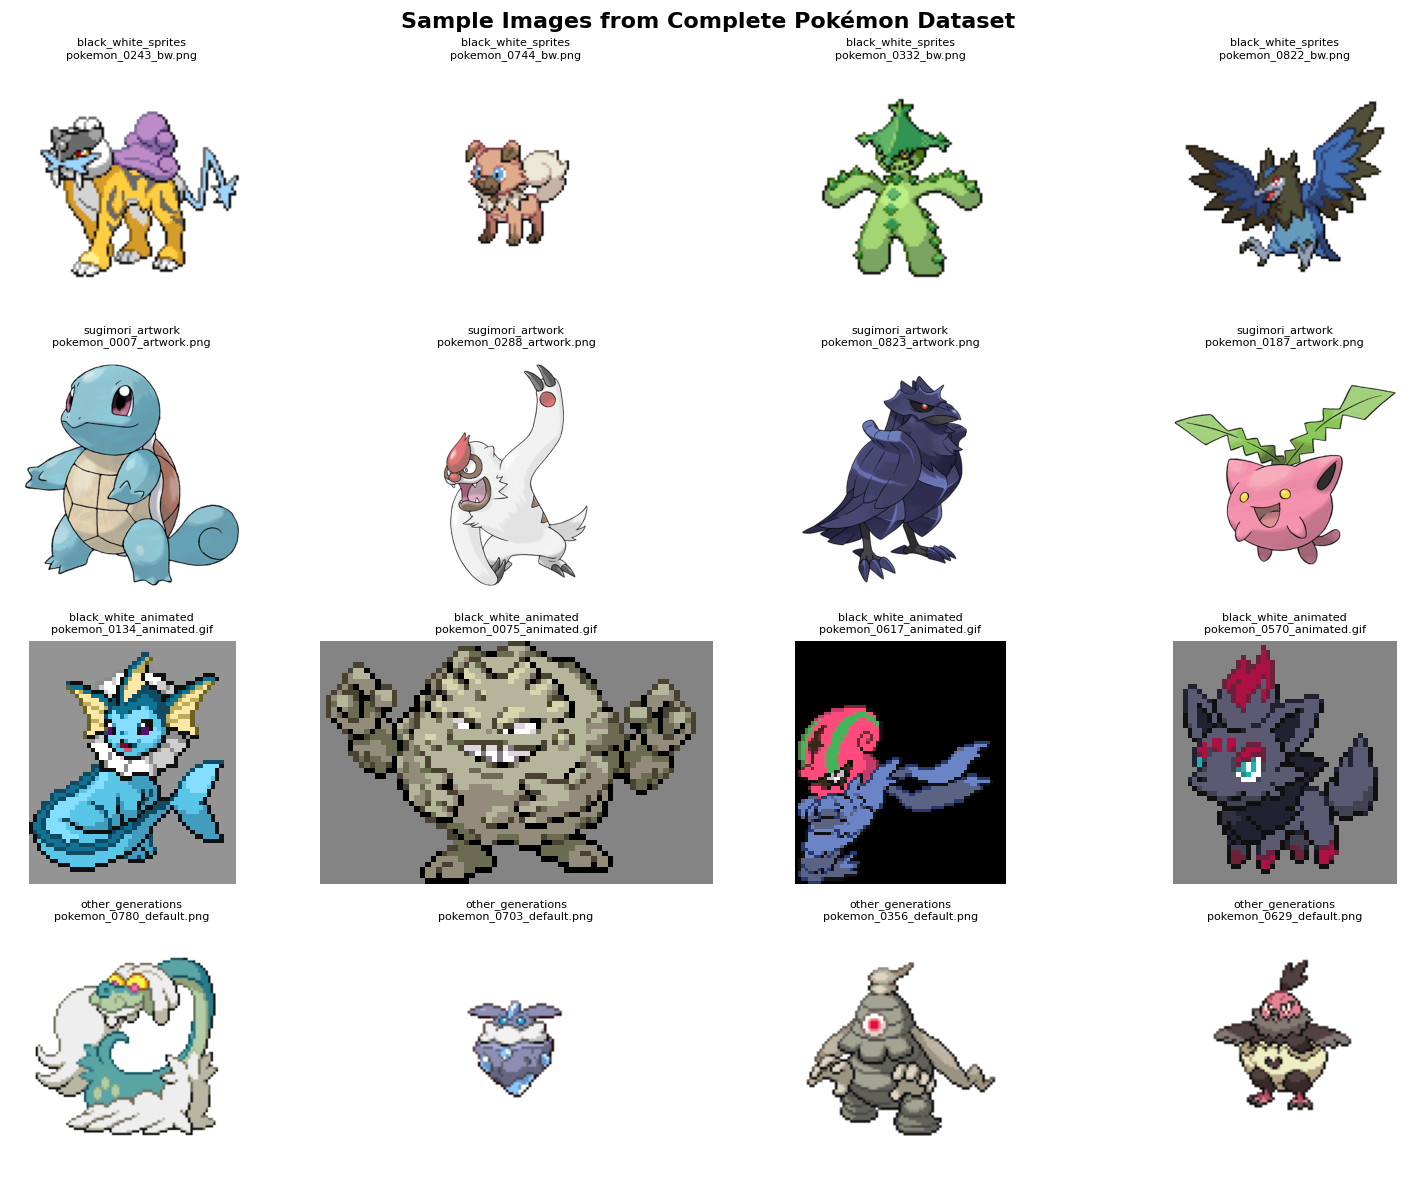

In [6]:
# Analyze the complete dataset
def analyze_complete_dataset(dataset_dir):
    """Analyze the comprehensive Pokémon dataset"""
    
    if not dataset_dir.exists():
        print("Dataset directory not found. Please run the download first.")
        return
    
    print(f"Analyzing complete dataset in: {dataset_dir}")
    
    # Get subdirectories
    subdirs = [d for d in dataset_dir.iterdir() if d.is_dir()]
    
    dataset_info = {}
    total_size = 0
    
    for subdir in subdirs:
        files = list(subdir.glob("*"))
        total_files = len(files)
        
        if total_files > 0:
            # Calculate total size
            subdir_size = sum(f.stat().st_size for f in files if f.is_file())
            total_size += subdir_size
            
            # Sample a few files for detailed analysis
            sample_files = files[:5] if len(files) >= 5 else files
            
            sizes = []
            dimensions = []
            
            for file_path in sample_files:
                if file_path.suffix.lower() in ['.png', '.jpg', '.jpeg']:
                    try:
                        img = Image.open(file_path)
                        dimensions.append((img.width, img.height))
                        sizes.append(file_path.stat().st_size)
                    except:
                        pass
            
            dataset_info[subdir.name] = {
                'total_files': total_files,
                'size_mb': subdir_size / (1024 * 1024),
                'avg_file_size': np.mean(sizes) if sizes else 0,
                'dimensions': dimensions
            }
    
    # Display analysis
    print(f"\nDataset Analysis Results:")
    print(f"Total dataset size: {total_size / (1024 * 1024):.1f} MB")
    print("=" * 60)
    
    for category, info in dataset_info.items():
        print(f"\n{category.replace('_', ' ').title()}:")
        print(f"   Files: {info['total_files']}")
        print(f"   Size: {info['size_mb']:.1f} MB")
        print(f"   Avg file size: {info['avg_file_size']:.0f} bytes")
        
        if info['dimensions']:
            widths = [d[0] for d in info['dimensions']]
            heights = [d[1] for d in info['dimensions']]
            print(f"   Sample dimensions: {min(widths)}x{min(heights)} to {max(widths)}x{max(heights)} pixels")

def visualize_dataset_samples(dataset_dir, samples_per_category=3):
    """Visualize samples from each category in the dataset"""
    
    if not dataset_dir.exists():
        print("Dataset directory not found.")
        return
    
    subdirs = [d for d in dataset_dir.iterdir() if d.is_dir()]
    
    fig, axes = plt.subplots(len(subdirs), samples_per_category, 
                            figsize=(4 * samples_per_category, 3 * len(subdirs)))
    
    if len(subdirs) == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle("Sample Images from Complete Pokémon Dataset", fontsize=16, fontweight='bold')
    
    for row, subdir in enumerate(subdirs):
        # Get image files
        image_files = [f for f in subdir.glob("*") if f.suffix.lower() in ['.png', '.jpg', '.jpeg', '.gif']]
        
        # Sample random files
        sample_files = random.sample(image_files, min(samples_per_category, len(image_files)))
        
        for col, img_file in enumerate(sample_files):
            try:
                if img_file.suffix.lower() == '.gif':
                    # For GIFs, load first frame
                    img = Image.open(img_file)
                    img = img.convert('RGB')
                else:
                    img = Image.open(img_file)
                
                axes[row, col].imshow(img)
                axes[row, col].set_title(f"{subdir.name}\n{img_file.name}", fontsize=8)
                axes[row, col].axis('off')
                
            except Exception as e:
                axes[row, col].text(0.5, 0.5, f'Error\nLoading\n{img_file.name}', 
                                   ha='center', va='center', transform=axes[row, col].transAxes)
                axes[row, col].axis('off')
        
        # Fill empty cells
        for col in range(len(sample_files), samples_per_category):
            axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

# If dataset was downloaded, analyze it
try:
    if 'complete_dataset_dir' in locals() and complete_dataset_dir.exists():
        analyze_complete_dataset(complete_dataset_dir)
        visualize_dataset_samples(complete_dataset_dir, samples_per_category=4)
    else:
        print("Run the download cell first to analyze the complete dataset.")
except Exception as e:
    print(f"Dataset analysis will be available after download completion.")

In [7]:
# Prepare data for training
def prepare_training_data(dataset_dir, target_size=(64, 64)):
    """Prepare the dataset for machine learning training"""
    
    if not dataset_dir.exists():
        print("Dataset directory not found.")
        return None, None
    
    print(f"Preparing training data with target size: {target_size}")
    
    # Create training directory structure
    training_dir = dataset_dir / "training_ready"
    training_dir.mkdir(exist_ok=True)
    
    # Separate directories for different use cases
    sprite_to_art_dir = training_dir / "sprite_to_artwork"  # For style transfer
    classification_dir = training_dir / "classification"    # For classification
    generation_dir = training_dir / "generation"           # For generation
    
    for dir_path in [sprite_to_art_dir, classification_dir, generation_dir]:
        dir_path.mkdir(exist_ok=True)
        (dir_path / "sprites").mkdir(exist_ok=True)
        (dir_path / "artwork").mkdir(exist_ok=True)
    
    # Process and organize the data
    bw_sprites_dir = dataset_dir / "black_white_sprites"
    sugimori_dir = dataset_dir / "sugimori_artwork"
    
    processed_count = 0
    paired_data = []
    
    if bw_sprites_dir.exists() and sugimori_dir.exists():
        sprite_files = list(bw_sprites_dir.glob("*.png"))
        
        for sprite_file in sprite_files:
            try:
                # Extract Pokémon ID from filename
                pokemon_id = sprite_file.stem.split('_')[1]
                
                # Find corresponding artwork
                artwork_file = sugimori_dir / f"pokemon_{pokemon_id}_artwork.png"
                
                if artwork_file.exists():
                    # Load and resize images
                    sprite_img = Image.open(sprite_file).convert('RGB')
                    artwork_img = Image.open(artwork_file).convert('RGB')
                    
                    # Resize images
                    sprite_resized = sprite_img.resize(target_size, Image.Resampling.LANCZOS)
                    artwork_resized = artwork_img.resize(target_size, Image.Resampling.LANCZOS)
                    
                    # Save processed images for different training purposes
                    
                    # 1. Sprite-to-artwork pairs (for style transfer/translation)
                    sprite_resized.save(sprite_to_art_dir / "sprites" / f"pokemon_{pokemon_id}.png")
                    artwork_resized.save(sprite_to_art_dir / "artwork" / f"pokemon_{pokemon_id}.png")
                    
                    # 2. Classification data (combine all as single dataset)
                    sprite_resized.save(classification_dir / "sprites" / f"pokemon_{pokemon_id}_sprite.png")
                    artwork_resized.save(classification_dir / "artwork" / f"pokemon_{pokemon_id}_artwork.png")
                    
                    # 3. Generation data (for GANs - separate by type)
                    sprite_resized.save(generation_dir / "sprites" / f"pokemon_{pokemon_id}.png")
                    artwork_resized.save(generation_dir / "artwork" / f"pokemon_{pokemon_id}.png")
                    
                    paired_data.append({
                        'pokemon_id': pokemon_id,
                        'sprite_path': sprite_to_art_dir / "sprites" / f"pokemon_{pokemon_id}.png",
                        'artwork_path': sprite_to_art_dir / "artwork" / f"pokemon_{pokemon_id}.png"
                    })
                    
                    processed_count += 1
                    
            except Exception as e:
                print(f"Error processing Pokémon {pokemon_id}: {e}")
        
        print(f"Processed {processed_count} Pokémon pairs")
        print(f"Training data saved to: {training_dir}")
        print(f"\nTraining datasets created:")
        print(f"  Sprite-to-Artwork: {len(list((sprite_to_art_dir / 'sprites').glob('*.png')))} pairs")
        print(f"  Classification: {len(list((classification_dir / 'sprites').glob('*.png')))} + {len(list((classification_dir / 'artwork').glob('*.png')))} images")
        print(f"  Generation: {len(list((generation_dir / 'sprites').glob('*.png')))} + {len(list((generation_dir / 'artwork').glob('*.png')))} images")
        
        return training_dir, paired_data
    
    else:
        print("Required source directories not found. Please complete the download first.")
        return None, None

def create_training_splits(training_dir, train_ratio=0.8, val_ratio=0.1):
    """Create train/validation/test splits for the processed data"""
    
    if not training_dir or not training_dir.exists():
        print("Training directory not found.")
        return
    
    sprite_to_art_dir = training_dir / "sprite_to_artwork"
    
    if not sprite_to_art_dir.exists():
        print("Sprite-to-artwork directory not found.")
        return
    
    # Get all sprite files
    sprite_files = list((sprite_to_art_dir / "sprites").glob("*.png"))
    
    # Shuffle and split
    random.shuffle(sprite_files)
    
    n_total = len(sprite_files)
    n_train = int(n_total * train_ratio)
    n_val = int(n_total * val_ratio)
    
    train_files = sprite_files[:n_train]
    val_files = sprite_files[n_train:n_train + n_val]
    test_files = sprite_files[n_train + n_val:]
    
    print(f"Dataset splits created:")
    print(f"   Training: {len(train_files)} pairs ({len(train_files)/n_total*100:.1f}%)")
    print(f"   Validation: {len(val_files)} pairs ({len(val_files)/n_total*100:.1f}%)")
    print(f"   Test: {len(test_files)} pairs ({len(test_files)/n_total*100:.1f}%)")
    
    # Save split information
    splits_info = {
        'train': [f.stem for f in train_files],
        'val': [f.stem for f in val_files],
        'test': [f.stem for f in test_files]
    }
    
    # Save to JSON for later use
    import json
    with open(training_dir / "data_splits.json", 'w') as f:
        json.dump(splits_info, f, indent=2)
    
    print(f"Split information saved to: {training_dir / 'data_splits.json'}")
    
    return splits_info

# Prepare data if dataset exists
try:
    if 'complete_dataset_dir' in locals() and complete_dataset_dir.exists():
        training_directory, paired_pokemon_data = prepare_training_data(complete_dataset_dir)
        if training_directory:
            data_splits = create_training_splits(training_directory)
    else:
        print("Training data preparation will be available after dataset download.")
except Exception as e:
    print(f"Data preparation will be available after download completion.")

Preparing training data with target size: (64, 64)


/home/khalil/DNN_tmp/venv/lib/python3.10/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Processed 898 Pokémon pairs
Training data saved to: ../data/pokemon_complete/training_ready

Training datasets created:
  Sprite-to-Artwork: 898 pairs
  Classification: 898 + 898 images
  Generation: 898 + 898 images
Dataset splits created:
   Training: 718 pairs (80.0%)
   Validation: 89 pairs (9.9%)
   Test: 91 pairs (10.1%)
Split information saved to: ../data/pokemon_complete/training_ready/data_splits.json
